In [51]:
# Populating the interactive namespace from numpy, pandas, matplotlib and datetime
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib.pyplot as plt

In [9]:
# reading the earthquakes data
all_earthquakes = pd.read_table('earthquakes/EMEC_data.txt', sep = ';', skiprows = 12, na_values = ' ')

# reading the values of the longitude and the latitude from the table
lat = all_earthquakes['latitude'].values
lon = all_earthquakes['longitude'].values

In [15]:
from math import *
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) usine haversine formula
    (which is said to be better for small distances)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of earth in kilometers is 6371
    dist = 6371000* c
    return dist

In [16]:
def declustering(all_earthquakes):
    
    """
    Finds the dependent earthquakes (fore- and aftershocks)
    using a method by Grünthal which is described in Burkhard and Grünthal (2009). 
    As an input receives the dataframe of the earthquake catalog. Returns: 1. the original
    dataframe with two additional columns: Declustering with True values for independent 
    earthquakes and the False values for the dependent earthquakes; and Decindex with 0 values
    for independent earthquakes and the indexes of the main earthquakes for the dependent earthquakes;
    2. dataframe of the independent earthquakes only.
    """

    # reading the values of the relevant columns from the table
    lat = all_earthquakes['latitude'].values
    lon = all_earthquakes['longitude'].values
    Mw = all_earthquakes['Mw '].values
    year = all_earthquakes['year'].values
    month = all_earthquakes['month'].values
    day = all_earthquakes['day'].values

    # converting the month and day to numeric values
    month = pd.to_numeric(month, errors = 'coerce')
    day = pd.to_numeric(day, errors = 'coerce')

    # filling nans in month and day with 6 and 15 respectfully (the middle of the year and the middle of the month)
    month = [6 if np.isnan(x) else int(x) for x in month]
    day = [15 if np.isnan(x) else int(x) for x in day]

    # defining all the earthquakes as independent (the declustring as True for every earthquake)
    declustering = (lat > 0)
    n = len(lat)
    i = 0
    decindex = 0*lat

    while True:

        if i > n - 1:
            break

        # calculating distance and time frames
        dR = np.exp(1.77 + np.sqrt(0.037 + 1.02*Mw[i]))
        if Mw[i] < 7.8:
            dTf = np.exp(-4.77 + np.sqrt(0.62 + 17.32*Mw[i]))
        else:
            dTf = np.exp(6.44 + 0.055*Mw[i])
        if Mw[i] < 6.6:
            dTa = np.exp(-3.95 + np.sqrt(0.62 + 17.32*Mw[i]))
        else:
            dTa = np.exp(6.44 + 0.055*Mw[i])

        # finding aftershocks
        d = 1
        while True:
            if i + d > n - 1:
                break

            # calculate the time difference between the current and the following (i+d) earthquake
            delta = datetime(year[i + d], month[i + d], day[i + d]) - datetime(year[i], month[i], day[i])
            timediff = delta.days

            # if the time difference is smaller than the time frame for the current magnitude 
            if timediff < dTa:

                # calculate the distance between the current and the following (i+d) earthquakes locations
                dist = haversine(lon[i], lat[i], lon[i + d], lat[i + d])

                # if the distance is smaller than the distance frame for the current magnitude, compare the magnitudes
                if dist/1000 < dR:

                    # if the magnitude of the following (i+d) earthquake is smaller than that of the current one 
                    if Mw[i] > Mw[i + d]:

                        # define the (i+d) earthquake as a dependent one (aftershock) 
                        # and save the index of the main earthquake
                        declustering[i + d] = False
                        decindex[i + d] = i

                # move to the next earthquake relative to the current one
                d = d + 1
            else:
                break    

        # finding foreshocks
        d = 1
        while True:
            if i - d < 0:
                break

            # calculate the time difference between the current and the previous (i-d) earthquake
            delta = datetime(year[i], month[i], day[i]) - datetime(year[i - d], month[i - d], day[i - d])
            timediff = delta.days

            # if the time difference is smaller than the time frame for the current magnitude 
            if timediff < dTf:

                # calculate the distance between the current and the previous (i-d) earthquakes locations
                dist = haversine(lon[i], lat[i], lon[i - d], lat[i - d])

                # if the distance is smaller than the distance frame for the current magnitude, compare the magnitudes
                if dist/1000 < dR:

                    # if the magnitude of the previous (i-d) earthquake is smaller than that of the current one 
                    if Mw[i] > Mw[i - d]:

                        # define the (i-d) earthquake as a dependent one (foreshock) 
                        # and save the index of the main earthquake
                        declustering[i - d] = False
                        decindex[i - d] = i

                # move to the next earthquake relative to the current one       
                d = d + 1
            else:
                break   

        # move to the next earthquake
        i = i + 1

    # add the declustering and the index columns to the dataframe
    all_earthquakes['Declustering'] = declustering
    all_earthquakes['Decindex'] = decindex

    # define a new filtered dataframe of the independent earthquakes only
    Declustered_earthquakes = all_earthquakes.iloc[:,:][all_earthquakes.Declustering == True]

    # droping the unnecessary columns
    Declustered_earthquakes = Declustered_earthquakes.drop(['Declustering', 'Decindex'], axis=1)
    
    return all_earthquakes, Declustered_earthquakes

In [17]:
# declustering the earthquake catalog
[all_earthquakes, Declustered_earthquakes] = declustering(all_earthquakes)

In [3]:
# reading the hellenic arc polygon coordinates data
hellenic_arc = pd.read_csv('earthquakes/first_hellenic_arc.csv', header=None)

In [5]:
# defining latitudes and longitudes of hellenic arc polygon
lats_vect = hellenic_arc[1].values
lons_vect = hellenic_arc[0].values

# adding the first point to the end to close the hellenic arc polygon
lats_vect = np.append(lats_vect, lats_vect[0])
lons_vect = np.append(lons_vect, lons_vect[0])

In [6]:
# Populating the interactive namespace from shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [7]:
lons_lats_vect = np.column_stack((lons_vect, lats_vect)) # Reshape coordinates
polygon = Polygon(lons_lats_vect) # create polygon

In [18]:
length = len(lon)
ind = []

# checking each entry in the earthquake catalog if it is located inside the hellenic arc polygon
# (True if it is and False if it isn't)
for i in range(length):
    dummy_ind = polygon.contains(Point(lon[i],lat[i]))
    ind.append(dummy_ind)
    
# adding the column of the indeces to the earthquakes dataframe
all_earthquakes['hellenic'] = ind

# extracting the hellenic arc earthquakes from the all earthquakes
crude_hellenic = all_earthquakes.iloc[:,:][all_earthquakes.hellenic == True]

In [19]:
# splitting the hellenic arc earthquakes into the magnitude classes of half a magnitude
crude_hellenic4 = crude_hellenic[(crude_hellenic['Mw '] > 3.75) & (crude_hellenic['Mw '] < 4.25)]
crude_hellenic45 = crude_hellenic[(crude_hellenic['Mw '] > 4.25) & (crude_hellenic['Mw '] < 4.75)]
crude_hellenic5 = crude_hellenic[(crude_hellenic['Mw '] > 4.75) & (crude_hellenic['Mw '] < 5.25)]
crude_hellenic55 = crude_hellenic[(crude_hellenic['Mw '] > 5.25) & (crude_hellenic['Mw '] < 5.75)]
crude_hellenic6 = crude_hellenic[(crude_hellenic['Mw '] > 5.75) & (crude_hellenic['Mw '] < 6.25)]
crude_hellenic65 = crude_hellenic[(crude_hellenic['Mw '] > 6.25) & (crude_hellenic['Mw '] < 6.75)]
crude_hellenic7 = crude_hellenic[(crude_hellenic['Mw '] > 6.75) & (crude_hellenic['Mw '] < 7.25)]
crude_hellenic75 = crude_hellenic[(crude_hellenic['Mw '] > 7.25) & (crude_hellenic['Mw '] < 7.75)]
crude_hellenic8 = crude_hellenic[(crude_hellenic['Mw '] > 7.75) & (crude_hellenic['Mw '] < 8.25)]

In [12]:
def calculate_completeness_time(name):
    
    """
    Calculating the cumulitave number of the earthquakes.
    As an input receives the dataframe of the earthquake catalog. Returns: the original
    dataframe with two additional columns: Count column of ones; and Cum_Count with cumulative 
    sum of the earthquakes; and one column less (indeces of the earthquake location inside the 
    hellenic arc polygon)
    """
    
    # deleting the column of indeces of the earthquake location inside the hellenic arc polygon
    name = name.drop(['hellenic'], axis=1)
    
    # adding the column of ones
    name['Count'] = np.ones(len(name))
    
    # adding the column of the cumulative sum of the earthquakes
    name['Cum_Count'] = name['Count'].cumsum()
    return name

In [52]:
def plot_normalized_comparative_completeness_time(name):
    
    """
    Plotting the normalized cumulitave number of the declustered and nondeclustered earthquakes.
    As an input receives the dataframe of the earthquake catalog. Plots on the same graph
    the normalized cumulitave number of the independent and the all earthquakes. Prints the 
    total number of earthquakes and the percentage of the dependent earthquakes.
    """
    
    # calculating the cumulative number of the all earthquakes
    all_earthquakes = calculate_completeness_time(name)
    
    # choosing only the independent earthquakes
    Declustered = name.iloc[:,:][name.Declustering == True]
    
    # calculating the cumulative number of the independent earthquakes
    declustered_earthquakes = calculate_completeness_time(Declustered)
    
    # calculating the percentage of the dependent earthquakes
    dependent_percentage = (len(name) - np.sum(name['Declustering']))/len(name)*100
    
    # plotting the staircase graph of normalized cumulitave number of the independent and all earthquakes.
    fig = plt.figure(figsize = (16, 8))
    plt.step(all_earthquakes['year'], all_earthquakes['Cum_Count']/np.max(all_earthquakes['Cum_Count']), 
             color = 'k', linewidth=2.0, label = 'All earthquakes')
    plt.step(declustered_earthquakes['year'], declustered_earthquakes['Cum_Count']/np.max(declustered_earthquakes['Cum_Count']), 
             color = 'r', linewidth=2.0, label = 'Independent earthquakes')
    plt.legend(fontsize=16)
    xloc = np.min(all_earthquakes['year']) 
    plt.text(xloc - 2.3, 0.8, 'Total number of earthquakes:', fontsize=16)
    plt.text(xloc - 2.3, 0.74, int(np.max(all_earthquakes['Cum_Count'])), fontsize=16)
    plt.text(xloc - 2.3, 0.6, 'Percentage of dependent earthquakes:', fontsize=16)
    plt.text(xloc - 2.3, 0.54, np.round(dependent_percentage, 2), fontsize=16)
    plt.xticks(fontsize=18, rotation=0)
    plt.yticks(fontsize=18, rotation=0)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Normalized cumulative number of earthquakes', fontsize=18, rotation=90)

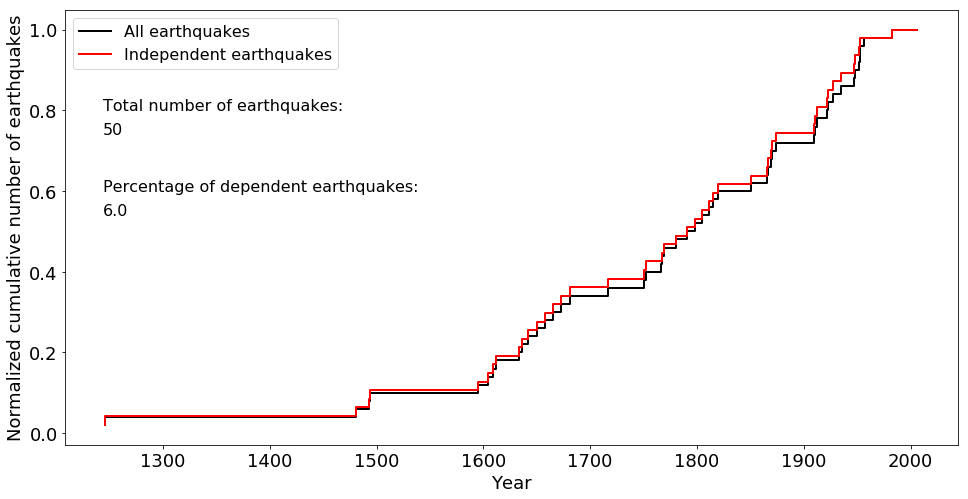

In [53]:
plot_normalized_comparative_completeness_time(crude_hellenic7)

In [54]:
def calculate_tempxy(name):
    
    """
    Expanding the x (Year) and the y (Cum_count) values for completness times graph drawing,
    that all the graphs for different magnitude classes will start at the same cumulative number
    and end at the same year.
    As an input receives the dataframe of the earthquake catalog. Returns x (Year) and the y (Cum_count) values
    for the graph plotting.
    """
    
    tempy = 0.1
    tempy = np.append(tempy,name['Cum_Count'].values)
    tempy = np.append(tempy,tempy[len(tempy) - 1])
    tempx = name['year'].values[0]
    tempx = np.append(tempx,name['year'].values)
    tempx = np.append(tempx,2006)
    return tempx, tempy

In [60]:
# calculating the cumulative number of the all earthquakes for Mw 8 and 7.5, since there 
# are no dependent earthquakes of such magnitude 
hellenic8 = calculate_completeness_time(crude_hellenic8)
hellenic75 = calculate_completeness_time(crude_hellenic75)

# calculating the cumulative number of the independent earthquakes for each magnitude class
Declustered = crude_hellenic4.iloc[:,:][crude_hellenic4.Declustering == True]
declustered4 = calculate_completeness_time(Declustered)
Declustered = crude_hellenic45.iloc[:,:][crude_hellenic45.Declustering == True]
declustered45 = calculate_completeness_time(Declustered)
Declustered = crude_hellenic5.iloc[:,:][crude_hellenic5.Declustering == True]
declustered5 = calculate_completeness_time(Declustered)
Declustered = crude_hellenic55.iloc[:,:][crude_hellenic55.Declustering == True]
declustered55 = calculate_completeness_time(Declustered)
Declustered = crude_hellenic6.iloc[:,:][crude_hellenic6.Declustering == True]
declustered6 = calculate_completeness_time(Declustered)
Declustered = crude_hellenic65.iloc[:,:][crude_hellenic65.Declustering == True]
declustered65 = calculate_completeness_time(Declustered)
Declustered = crude_hellenic7.iloc[:,:][crude_hellenic7.Declustering == True]
declustered7 = calculate_completeness_time(Declustered)

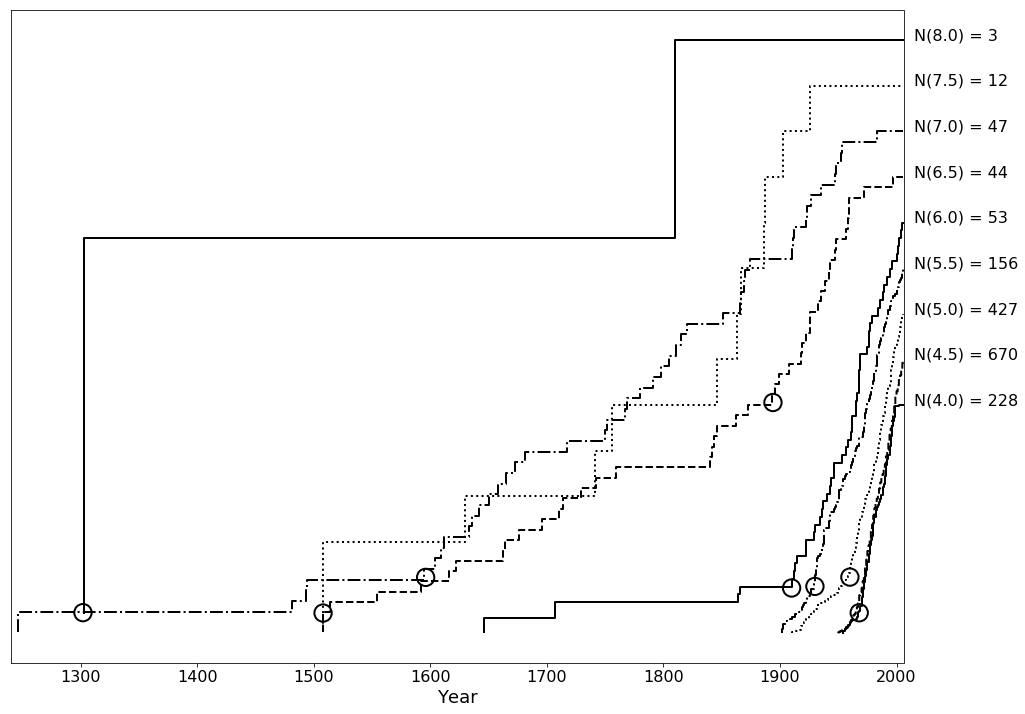

In [62]:
# plotting the cumulative graph of catalogue entries (N) for the Hellenic arc for each magnitude class. 
# The ordinate, displaying the cumulative numbers, is given in arbitrary units, i.e. different for each 
# graph representing one magnitude class. The open dots indicate the times from which on a sufficient 
# completeness is assumed. 
fig = plt.figure(figsize = (16, 12))
[tempx, tempy] = calculate_tempxy(hellenic8)
plt.step(tempx, tempy*2.6/np.max(hellenic8['Cum_Count']), color = 'k', 
         linewidth=2.0)
plt.xlim(1240, 2006)
[tempx, tempy] = calculate_tempxy(hellenic75)
plt.step(tempx, tempy*2.4/np.max(hellenic75['Cum_Count']), color = 'k', linestyle = ':', 
         linewidth=2.0)

[tempx, tempy] = calculate_tempxy(declustered7)
plt.step(tempx, tempy*2.2/np.max(declustered7['Cum_Count']), color = 'k', linestyle = '-.',
         linewidth=2.0)
[tempx, tempy] = calculate_tempxy(declustered65)
plt.step(tempx, tempy*2/np.max(declustered65['Cum_Count']), color = 'k', linestyle = '--',
         linewidth=2.0)
[tempx, tempy] = calculate_tempxy(declustered6)
plt.step(tempx, tempy*1.8/np.max(declustered6['Cum_Count']), color = 'k', 
         linewidth=2.0)
[tempx, tempy] = calculate_tempxy(declustered55)
plt.step(tempx, tempy*1.6/np.max(declustered55['Cum_Count']), color = 'k', linestyle = '-.',
         linewidth=2.0)
[tempx, tempy] = calculate_tempxy(declustered5)
plt.step(tempx, tempy*1.4/np.max(declustered5['Cum_Count']), color = 'k', linestyle = ':',
         linewidth=2.0)
[tempx, tempy] = calculate_tempxy(declustered45)
plt.step(tempx, tempy*1.2/np.max(declustered45['Cum_Count']), color = 'k', linestyle = '--',
         linewidth=2.0)
[tempx, tempy] = calculate_tempxy(declustered4)
plt.step(tempx, tempy/np.max(declustered4['Cum_Count']), color = 'k',
         linewidth=2.0)
plt.yticks([], [])
plt.xticks(fontsize=16, rotation=0)
plt.xlabel('Year', fontsize=18)
plt.text(2015, 2.6, 'N(8.0) = 3', fontsize=16)
plt.text(2015, 2.4, 'N(7.5) = 12', fontsize=16)
plt.text(2015, 2.2, 'N(7.0) = 47', fontsize=16)
plt.text(2015, 2.0, 'N(6.5) = 44', fontsize=16)
plt.text(2015, 1.8, 'N(6.0) = 53', fontsize=16)
plt.text(2015, 1.6, 'N(5.5) = 156', fontsize=16)
plt.text(2015, 1.4, 'N(5.0) = 427', fontsize=16)
plt.text(2015, 1.2, 'N(4.5) = 670', fontsize=16)
plt.text(2015, 1.0, 'N(4.0) = 228', fontsize=16)
plt.scatter(1968, 60/np.max(declustered45['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)
plt.scatter(1960, 105/np.max(declustered5['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)
plt.scatter(1930, 32/np.max(declustered55['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)
plt.scatter(1910, 10.5/np.max(declustered6['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)
plt.scatter(1894, 44.5/np.max(declustered65['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)
plt.scatter(1596, 11.5/np.max(declustered7['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)
plt.scatter(1508, 1.06/np.max(hellenic75['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)
plt.scatter(1302, 0.27/np.max(hellenic8['Cum_Count']), 300, marker = 'o', color = 'k', facecolors='none', linewidth=2.0)

In [63]:
# choosing complete part of catalog of independent earthquakes for each magnitude class
declustered7_complete = declustered7[(declustered7['year'] > 1595)]
declustered65_complete = declustered65[(declustered65['year'] > 1893)]
declustered6_complete = declustered6[(declustered6['year'] > 1909)]
declustered55_complete = declustered55[(declustered55['year'] > 1929)]
declustered5_complete = declustered5[(declustered5['year'] > 1959)]
declustered45_complete = declustered45[(declustered45['year'] > 1967)]
declustered4_complete = declustered4[(declustered4['year'] > 1969)]

In [67]:
# combining together complete parts of catalog of independent earthquakes of all magnitude classes
declustered_complete = pd.concat([hellenic75, hellenic8, declustered4_complete, declustered45_complete, 
                                  declustered5_complete, declustered55_complete, 
                                 declustered6_complete, declustered65_complete, declustered7_complete])

# sorting the complete part of catalog of independent earthquakes by time of the occurrence
declustered_complete = declustered_complete.sort_index()

# dropping the unnecessary columns
declustered_complete = declustered_complete.drop(['Declustering', 'Decindex', 'Count', 'Cum_Count'], axis=1)

In [69]:
# choosing complete part of catalog of all the earthquakes for each magnitude class
nondeclustered7_complete = crude_hellenic7[(crude_hellenic7['year'] > 1595)]
nondeclustered65_complete = crude_hellenic65[(crude_hellenic65['year'] > 1893)]
nondeclustered6_complete = crude_hellenic6[(crude_hellenic6['year'] > 1909)]
nondeclustered55_complete = crude_hellenic55[(crude_hellenic55['year'] > 1929)]
nondeclustered5_complete = crude_hellenic5[(crude_hellenic5['year'] > 1959)]
nondeclustered45_complete = crude_hellenic45[(crude_hellenic45['year'] > 1967)]
nondeclustered4_complete = crude_hellenic4[(crude_hellenic4['year'] > 1969)]

In [71]:
# combining together complete parts of catalog of all the earthquakes of all magnitude classes
nondeclustered_complete = pd.concat([crude_hellenic75, crude_hellenic8, nondeclustered4_complete, 
                                     nondeclustered45_complete, nondeclustered5_complete, nondeclustered55_complete, 
                                 nondeclustered6_complete, nondeclustered65_complete, nondeclustered7_complete])

# sorting the complete part of catalog of all the earthquakes by time of the occurrence
nondeclustered_complete = nondeclustered_complete.sort_index()

# dropping the unnecessary columns
nondeclustered_complete = nondeclustered_complete.drop(['Declustering', 'Decindex', 'hellenic'], axis=1)

In [72]:
nondeclustered_complete

,year,month,day,hour,minute,latitude,longitude,depth,intensity,M_orig,type,Mw,Mw_err,reference
76,1303,8,8,6,,35.00,27.00,,10,8,w,8.0,,Pdo07
232,1508,5,29,,,35.05,25.70,,10,7.5,w,7.5,0.35,Pap
320,1604,,,,,35.80,25.20,,7,7,w,7.0,0.5,Pap
325,1609,4,,,,36.40,28.33,,9,7.2,w,7.2,,Pdo07
330,1612,11,8,,,35.50,25.20,,8,7,w,7.0,0.5,Pap
355,1630,3,10,9,,35.00,23.70,,9,7.3,w,7.3,0.5,Pap
362,1633,11,5,,,37.70,20.80,,9,7,w,7.0,0.5,Pap
367,1636,9,30,,,38.10,20.30,,9,7.2,w,7.2,0.35,Pap
373,1642,5,30,,,36.80,21.70,,8,6.8,w,6.8,0.5,Pap
384,1650,10,9,,,36.50,25.50,,8,7,w,7.0,0.5,Pap


In [73]:
declustered_complete

,year,month,day,hour,minute,latitude,longitude,depth,intensity,M_orig,type,Mw,Mw_err,reference
76,1303,8,8,6,,35.00,27.00,,10,8,w,8.0,,Pdo07
232,1508,5,29,,,35.05,25.70,,10,7.5,w,7.5,0.35,Pap
320,1604,,,,,35.80,25.20,,7,7,w,7.0,0.5,Pap
325,1609,4,,,,36.40,28.33,,9,7.2,w,7.2,,Pdo07
330,1612,11,8,,,35.50,25.20,,8,7,w,7.0,0.5,Pap
355,1630,3,10,9,,35.00,23.70,,9,7.3,w,7.3,0.5,Pap
362,1633,11,5,,,37.70,20.80,,9,7,w,7.0,0.5,Pap
367,1636,9,30,,,38.10,20.30,,9,7.2,w,7.2,0.35,Pap
373,1642,5,30,,,36.80,21.70,,8,6.8,w,6.8,0.5,Pap
384,1650,10,9,,,36.50,25.50,,8,7,w,7.0,0.5,Pap


In [74]:
# saving the complete catalogs
declustered_complete.to_csv('earthquakes/declustered_complete.csv')
nondeclustered_complete.to_csv('earthquakes/nondeclustered_complete.csv')

In [75]:
a = pd.read_table('earthquakes/declustered_complete.csv', sep = ',', na_values = ' ')

In [76]:
a

,Unnamed: 0,year,month,day,hour,minute,latitude,longitude,depth,intensity,M_orig,type,Mw,Mw_err,reference
0,76,1303,8,8,6,,35.00,27.00,,10,8.0,w,8.0,,Pdo07
1,232,1508,5,29,,,35.05,25.70,,10,7.5,w,7.5,0.35,Pap
2,320,1604,,,,,35.80,25.20,,7,7.0,w,7.0,0.5,Pap
3,325,1609,4,,,,36.40,28.33,,9,7.2,w,7.2,,Pdo07
4,330,1612,11,8,,,35.50,25.20,,8,7.0,w,7.0,0.5,Pap
5,355,1630,3,10,9,,35.00,23.70,,9,7.3,w,7.3,0.5,Pap
6,362,1633,11,5,,,37.70,20.80,,9,7.0,w,7.0,0.5,Pap
7,367,1636,9,30,,,38.10,20.30,,9,7.2,w,7.2,0.35,Pap
8,373,1642,5,30,,,36.80,21.70,,8,6.8,w,6.8,0.5,Pap
9,384,1650,10,9,,,36.50,25.50,,8,7.0,w,7.0,0.5,Pap
